In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
conn = engine.connect()

## Bonus Challenge Assignment: Temperature Analysis II

In [10]:

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


print(calc_temps('2017-08-01', '2017-08-07'))

[(22.2, 26.25, 28.3)]


In [12]:
Measurement_data = pd.read_sql("SELECT * FROM measurement", conn)
Measurement_data

,id,station,date,prcp,tobs
0,0,USC00519397,2010-01-01,2.0,18.3
1,1,USC00519397,2010-01-02,0.0,17.2
2,2,USC00519397,2010-01-03,0.0,23.3
3,3,USC00519397,2010-01-04,0.0,24.4
4,4,USC00519397,2010-01-06,NaN,22.8
...,...,...,...,...,...
19545,19545,USC00516128,2017-08-19,2.3,21.7
19546,19546,USC00516128,2017-08-20,NaN,25.6
19547,19547,USC00516128,2017-08-21,14.2,24.4
19548,19548,USC00516128,2017-08-22,12.7,24.4


In [13]:
Station_data = pd.read_sql("SELECT * FROM station", conn)
Station_data

,id,station,name,latitude,longitude,elevation
0,0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,0.914
1,1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,4.450
2,2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,2.133
3,3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,3.627
4,4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,93.447
5,5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,5.943
6,6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,10.027
7,7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.274
8,8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,46.449


In [14]:

print(calc_temps('2017-08-01', '2017-08-07'))

[(22.2, 26.25, 28.3)]


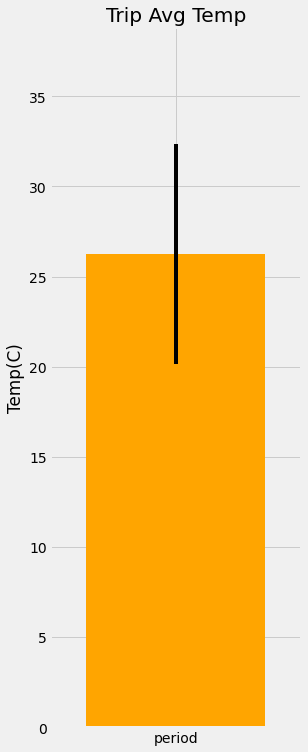

In [15]:
# Plot the results from your previous query as a bar chart. 
temps = list(np.ravel(calc_temps('2017-08-01', '2017-08-07')))
#df = pd.DataFrame(calc_temps('2017-08-01', '2017-08-07'))
temps[0]
#df.head()
fig, ax = plt.subplots(figsize=plt.figaspect(3))
x_period = ['period']
counts = temps[1]


ax.bar(x_period, counts, align = 'center', color = 'orange', yerr=temps[2] - temps[0])

ax.margins(0.2,0.2)
ax.set_ylabel('Temp(C)')
ax.set_title('Trip Avg Temp')

plt.show()

### Daily Rainfall Average

In [16]:
# Total amount of rainfall per weather station for your trip dates using the previous year's matching dates.

Rainfall_date_range = pd.DataFrame(session.query(Measurement.station,Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= '2017-08-01').filter(Measurement.date <= '2017-08-07').all())

prcp_byStation = pd.DataFrame(Rainfall_date_range.groupby(by=["station"]).sum().reset_index())

merged_prcp_station = pd.merge(prcp_byStation, Station_data, on=["station", "station"])
merged_prcp_station.sort_values(by='prcp', ascending=False)


,station,prcp,id,name,latitude,longitude,elevation
1,USC00516128,9.2,8,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,46.449
0,USC00514830,5.6,2,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,2.133
2,USC00519281,1.5,6,"WAIHEE 837.5, HI US",21.45167,-157.84889,10.027
3,USC00519397,1.0,0,"WAIKIKI 717.2, HI US",21.27160,-157.81680,0.914
4,USC00519523,0.0,5,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,5.943


### Daily Temperature Normals

In [17]:
# Use this function to calculate the daily normals 

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
#daily_normals("01-01")

In [52]:
# calculate the daily normals for your trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
Date_range = pd.date_range(start= start_date, end= end_date)
#Date_range[0]

# Strip off the year and save a list of strings in the format %m-%d
Date_range_md = Date_range.strftime('%m-%d')


normals = []


In [53]:
for date in Date_range_md:
    for x in daily_normals(date):
        normals.append(x)
normals

[(19.4, 24.186, 28.3),
 (20.0, 24.220754716981123, 28.9),
 (21.1, 24.77777777777778, 29.4),
 (20.6, 24.84038461538462, 28.9),
 (20.6, 24.529629629629632, 27.8),
 (19.4, 24.582142857142852, 28.3),
 (21.7, 25.08235294117647, 28.3)]

In [57]:
#normals_temp = {'trip_dates': Date_range, 'Temp_data': normals}
normals_df = pd.DataFrame(normals, columns = ['tmin','tavg','tmax'])
normals_df['trip_dates'] = Date_range
normals_df.set_index('trip_dates', inplace = True)
normals_df

,tmin,tavg,tmax
trip_dates,,,
2017-08-01,19.4,24.186000,28.3
2017-08-02,20.0,24.220755,28.9
2017-08-03,21.1,24.777778,29.4
2017-08-04,20.6,24.840385,28.9
2017-08-05,20.6,24.529630,27.8
2017-08-06,19.4,24.582143,28.3
2017-08-07,21.7,25.082353,28.3


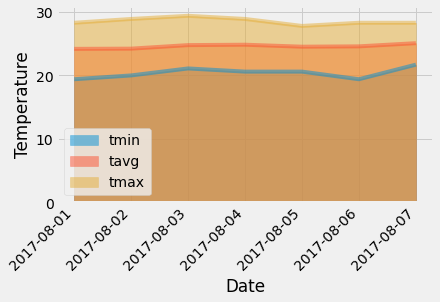

In [61]:
normals_df = normals_df.sort_values('trip_dates',ascending = True)
normals_df.plot.area(stacked=False, x_compat=True)
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.show()

## Close Session

In [62]:
session.close()